In [ ]:
#!pip install pmdarima

In [ ]:
# Import Libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [ ]:
do = pd.read_csv('/content/ACTUAL_DATASET.csv')
data =do.iloc[:1440]
del data['CPU']
data.columns = ['Time','Request']
data['Time'] = pd.to_datetime(data['Time'], format='%d.%m.%Y %H:%M:%S')
Time = data.pop('Time')
data.head()

,Request
0,739
1,963
2,824
3,499
4,292


In [ ]:
data.mean()

Request    337.9125
dtype: float64

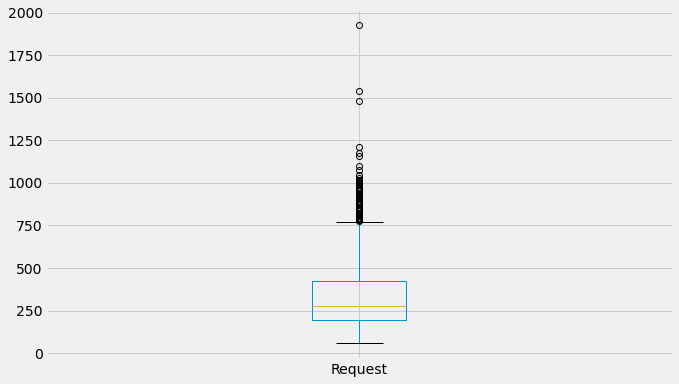

In [ ]:
data.boxplot()

In [ ]:
import numpy as np
for x in ['Request']:
    q75,q25 = np.percentile(data.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    data.loc[data[x] < min,x] = np.nan
    data.loc[data[x] > max,x] = np.nan

In [ ]:
data.isnull().sum()

Request    71
dtype: int64

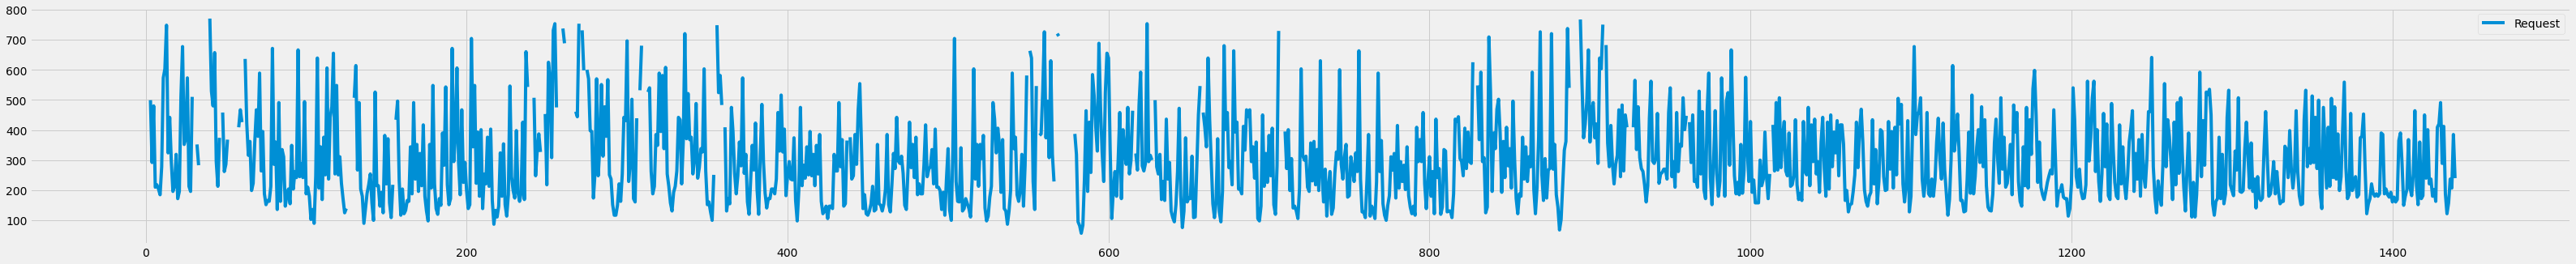

In [ ]:
data.plot(figsize=(50,5))

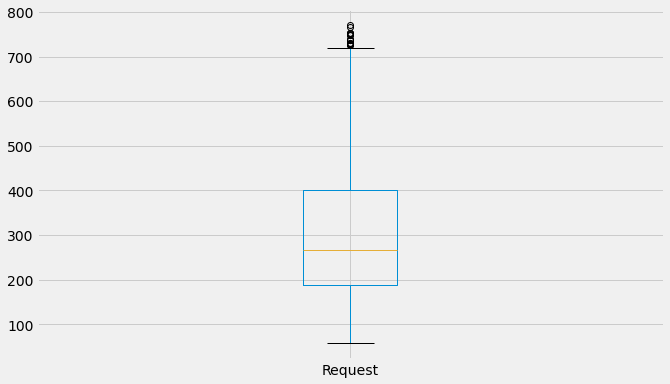

In [ ]:
data.boxplot()

In [ ]:
data.mean()

Request    306.71439
dtype: float64

In [ ]:
!pip install fancyimpute
from sklearn.impute import KNNImputer
from fancyimpute import KNN
missing_col = ['Request']
for i in missing_col:
 data.loc[data.loc[:,i].isnull(),i]=data.loc[:,i].mean()

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data)

print('ADF Statistic: %f' % adf_test[0])
print('No of Lags: %f' % adf_test[2])
print('No of Observations: %f' % adf_test[3])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -5.211369
No of Lags: 24.000000
No of Observations: 1415.000000
Critical Values @ 0.05: -2.86
p-value: 0.000008


<Figure size 720x432 with 0 Axes>

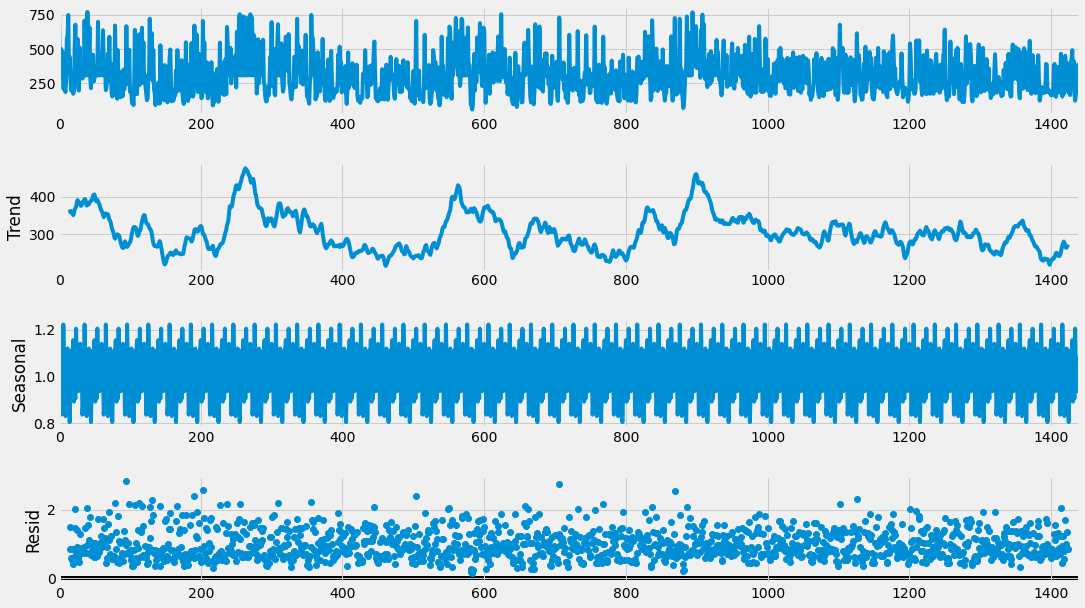

In [ ]:
result = seasonal_decompose(data, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


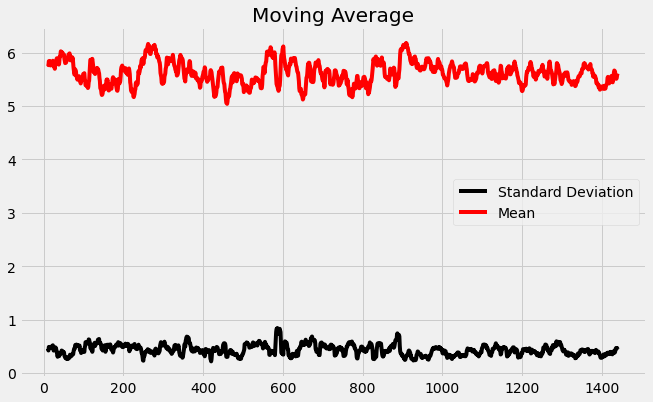

In [ ]:
# Convert data on Log to reduce the magnitude of the values and reduce the rising trend in the series 
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(data)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

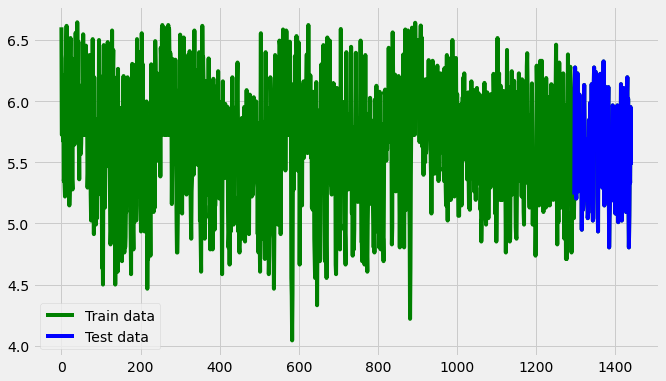

In [ ]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [ ]:
# Check the corrct values and model
model_autoARIMA1 = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA1.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8147.222, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6657.227, Time=0.48 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1727.457, Time=1.43 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1597.607, Time=2.23 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1592.913, Time=3.91 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=1582.882, Time=4.00 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.77 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=1488.687, Time=6.77 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1487.965, Time=5.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1681.807, Time=3.18 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=1488.139, Time=1.64 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1502.030, T

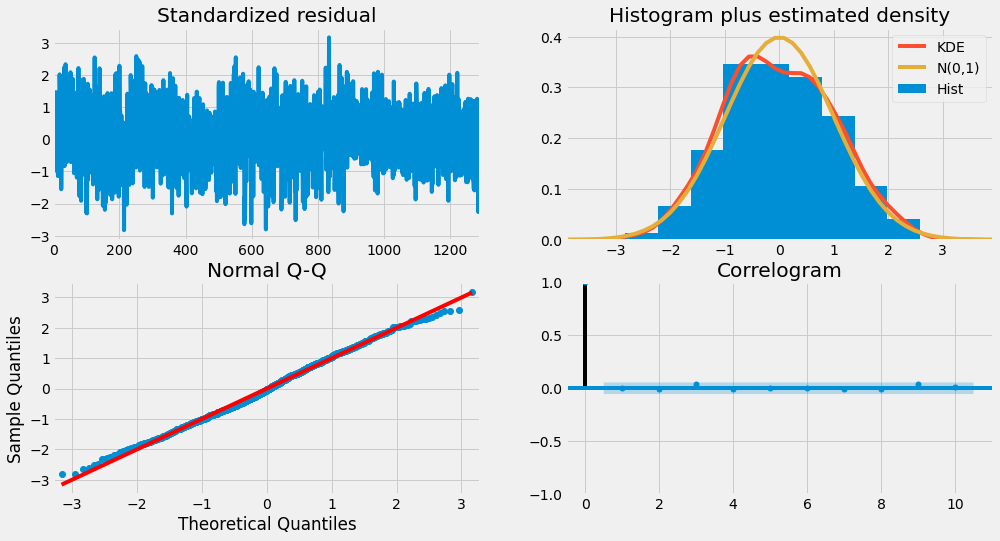

In [ ]:
# Residual Data plot
model_autoARIMA1.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
import statsmodels.api as sm

In [ ]:
# Fit the data on ARMA modeal with parameter (3,3)
model = sm.tsa.arima.ARIMA(train_data, order=(2, 0, 2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                Request   No. Observations:                 1293
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -733.085
Date:                Fri, 22 Apr 2022   AIC                           1478.169
Time:                        04:37:47   BIC                           1509.157
Sample:                             0   HQIC                          1489.799
                               - 1293                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6247      0.021    265.311      0.000       5.583       5.666
ar.L1         -0.5917      0.055    -10.704      0.000      -0.700      -0.483
ar.L2          0.4049      0.055      7.309      0.0

In [ ]:
# ljungbox test
import statsmodels.api as sm
sm.stats.acorr_ljungbox(fitted.resid, lags=[20], return_df=True)

,lb_stat,lb_pvalue
20,38.840135,0.006979


1296    5.558420
1297    5.409226
1298    5.725372
1299    5.477883
1300    5.752349
          ...   
1565    5.553724
1566    5.695518
1567    5.554060
1568    5.695183
1569    5.554394
Name: predicted_mean, Length: 274, dtype: float64


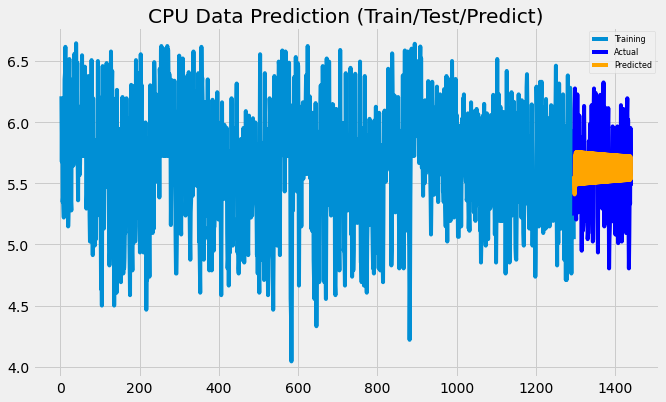

In [ ]:
fc = fitted.forecast(274, alpha=0.05) 
print(fc) # 95% confidence
fc_series = pd.Series(fc, index=test_data.index, name="Request")
plt.plot(train_data, label='Training')
plt.plot(test_data, color = 'blue', label='Actual')
plt.plot(fc_series, color = 'orange',label='Predicted')
plt.title('CPU Data Prediction (Train/Test/Predict)')
plt.legend(loc='upper right', fontsize=8)
plt.show()

In [ ]:
p = fc_series.to_frame()
fc = fc[:144]
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test_data['Request']- p['Request']/np.abs(test_data['Request'])))
print('MAPE: '+str(mape))
mpe = np.mean((test_data['Request']- p['Request']/np.abs(test_data['Request'])*100))
print('MPE: '+str(mpe))
me = np.mean(test_data['Request']- p['Request'])
print('ME: '+str(me))

MSE: 0.1504605892871197
MAE: 0.3298972594363744
RMSE: 0.38789249707505263
MAPE: 4.511386808021124
MPE: -96.55527105788823
ME: -0.09023280129471613


In [ ]:
model_pr = sm.tsa.arima.ARIMA(df_log, order=(3, 0, 3))  
fitted_pr = model_pr.fit()  
print(fitted_pr.summary())

                               SARIMAX Results                                
Dep. Variable:                Request   No. Observations:                 1440
Model:                 ARIMA(3, 0, 3)   Log Likelihood                -793.452
Date:                Fri, 22 Apr 2022   AIC                           1602.904
Time:                        04:38:14   BIC                           1645.083
Sample:                             0   HQIC                          1618.649
                               - 1440                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6223      0.034    164.886      0.000       5.555       5.689
ar.L1          0.2341      0.078      3.002      0.003       0.081       0.387
ar.L2          0.9766      0.015     66.117      0.0

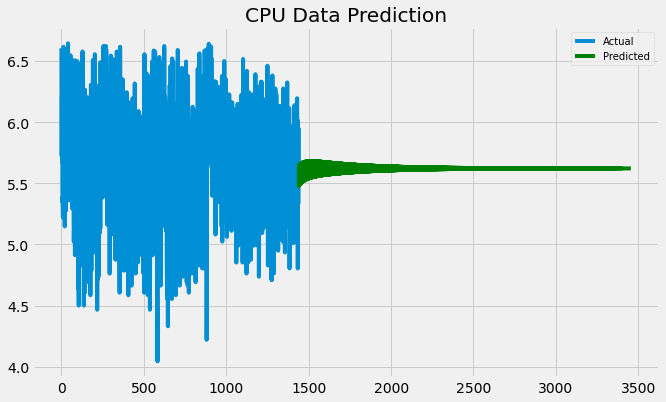

In [ ]:
x = pd.Series(range(test_data.index.max()+1,4752))
fc_pr = fitted_pr.forecast(2016, alpha=0.05)  # 95% confidence
fc_series_pr = pd.Series(fc_pr, index = x, name="Request")
plt.plot(df_log, label='Actual')
plt.plot(fc_series_pr, color = 'green',label='Predicted')
plt.title('CPU Data Prediction')
plt.legend(loc='upper right', fontsize=10)
plt.show()

In [ ]:
pridict_data_CPU = np.round((np.exp(fc_series_pr)),0)
pridict_data_CPU.head()

1440    279.0
1441    239.0
1442    284.0
1443    241.0
1444    285.0
Name: Request, dtype: float64

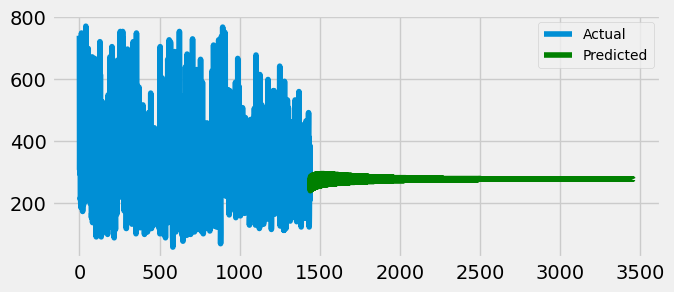

In [ ]:
# Plot the actualy (Recovered) series with actual
plt.figure(figsize=(7,3), dpi=100)
plt.plot(data, label='Actual')
plt.plot(pridict_data_CPU, color = 'green',label='Predicted')
plt.legend(loc='upper right', fontsize=10)
plt.show()

In [ ]:
# Export data in 'pridict_data_CPU.csv' 
pridict_data_CPU.to_csv(r'Memoryy.csv', index = False)